In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import os 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [2]:
audio_dataframe = pd.read_csv('label_dataframe.csv') 
audio_dataframe.head()

,file_name,label,instrument,type_of_sound,root_note,chord_type
0,0000.wav,C:maj,non_guitar,Jazz_Organ,C,maj
1,0001.wav,C:maj/3,non_guitar,Jazz_Organ,C,maj/3
2,0002.wav,C:maj/5,non_guitar,Jazz_Organ,C,maj/5
3,0003.wav,C#:maj,non_guitar,Jazz_Organ,C#,maj
4,0004.wav,C#:maj/3,non_guitar,Jazz_Organ,C#,maj/3


In [3]:

columns_to_drop = ['label', 'instrument', 'type_of_sound', 'chord_type']

X = audio_dataframe.drop(columns=columns_to_drop, axis=1)
y = audio_dataframe['root_note']

X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_full_train, X_val, y_train, y_val = train_test_split(X_full_train, y_train, test_size=0.25, random_state=42)


In [4]:
simple_approach_dataframe = pd.DataFrame(columns=['file_name', 'root_note', 'chord_type', '0:C', '1:C#', '2:D', '3:D#', '4:E', '5:F', '6:F#', '7:G', '8:G#', '9:A', '10:A#', '11:B'])
simple_approach_dataframe.to_csv('simple_approach_dataframe.csv', index=False)

In [6]:
simple_approach_dataframe = pd.DataFrame(columns = ['file_name','root_note', 'chord_type', 'instrument', '0:C', '1:C#', '2:D', '3:D#', '4:E', '5:F', '6:F#', '7:G', '8:G#', '9:A', '10:A#', '11:B'])
for index, row in audio_dataframe.iterrows(): 
    file_name = row['file_name']
    root_note = row['root_note']
    chord_type = row['chord_type']
    intstrument = row['instrument']
    id = os.path.split(file_name)[-1].split('.')[0] 
    filename_chromagram = id + '_chromagram.npy'
    chromagram = np.load(os.path.join('IDMT-SMT-CHORDS/chromagrams', filename_chromagram))
    data_list = [file_name, root_note, chord_type, intstrument]
    for i in range(12):
        data_list.append(np.sum(chromagram[i]))

    simple_approach_dataframe.loc[index] = data_list
simple_approach_dataframe.to_csv('simple_approach_dataframe.csv', index=False)

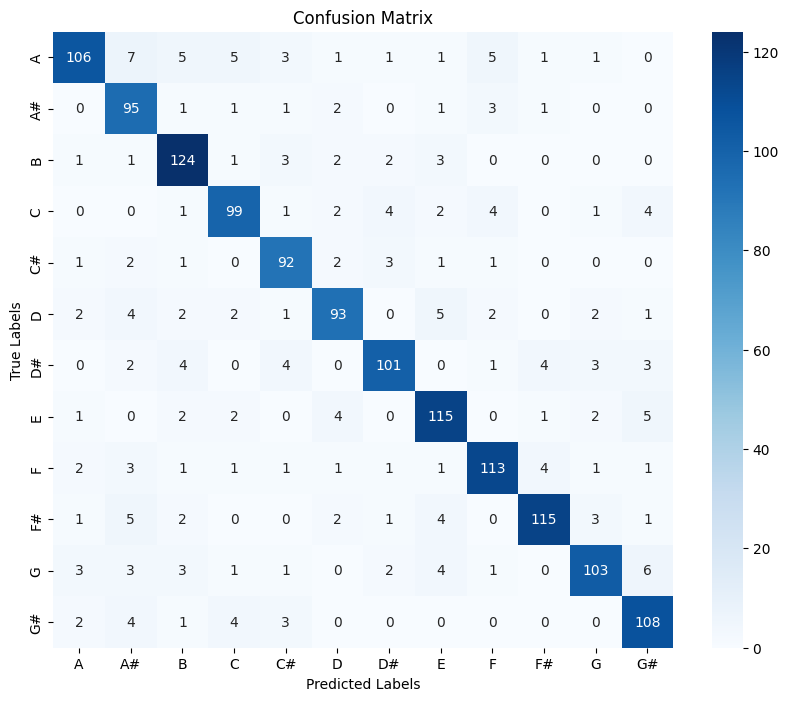

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       136
           1       0.75      0.90      0.82       105
           2       0.84      0.91      0.87       137
           3       0.85      0.84      0.85       118
           4       0.84      0.89      0.86       103
           5       0.85      0.82      0.83       114
           6       0.88      0.83      0.85       122
           7       0.84      0.87      0.86       132
           8       0.87      0.87      0.87       130
           9       0.91      0.86      0.88       134
          10       0.89      0.81      0.85       127
          11       0.84      0.89      0.86       122

    accuracy                           0.85      1480
   macro avg       0.85      0.86      0.85      1480
weighted avg       0.86      0.85      0.85      1480



In [25]:
label_encoder = LabelEncoder()
simple_approach_dataframe['root_note'] = label_encoder.fit_transform(simple_approach_dataframe['root_note'])
# Splitting data into train and test sets
simple_approach_dataframe.to_csv('label_encoder_simple_approach_df.csv', index=False)
X_full_train, X_full_test, y_train, y_test = train_test_split(simple_approach_dataframe.drop(columns='root_note'), simple_approach_dataframe['root_note'], test_size=0.2, random_state=42)
X_train = X_full_train.drop(columns=['file_name', 'instrument', 'chord_type'])
X_test = X_full_test.drop(columns=['file_name', 'instrument', 'chord_type'])

# Fitting a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Running inference on test set
y_pred = rf_classifier.predict(X_test)
# Computing classification metrics
classification_metrics = classification_report(y_test, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)

Filtramos para comprobar solo con los acordes normales (no invertidos, maj min)

In [26]:
def filter_chords(X, y_test, column_name='chord_type'):
    """Filter the dataframe into normal chords and inversions based on the chord type column.

    Args:
        df (pd.DataFrame): The dataframe to filter.
        column_name (str): The name of the column to check for inversions (default 'chord_type').

    Returns:
        tuple: Two dataframes, the first with normal chords, the second with inversions.
    """
    df = pd.concat([X, y_test], axis=1) 
    normal_chords = df[~df[column_name].str.contains('/')]
    inversions = df[df[column_name].str.contains('/')]
    # get the indexes of the dataframe that contains normal chords  
    X_normal = normal_chords.drop(columns='root_note')
    y_normal = normal_chords['root_note']   

    X_inversions = inversions.drop(columns='root_note')
    y_inversions = inversions['root_note']
    

    X_normal = X_normal.drop(columns=['file_name', 'instrument', 'chord_type']) 
    X_inversions = X_inversions.drop(columns=['file_name', 'instrument', 'chord_type'])
    return X_normal, y_normal, X_inversions, y_inversions   


In [27]:
X_normal, y_normal, X_inversions, y_inversions = filter_chords(X_full_test, y_test)     

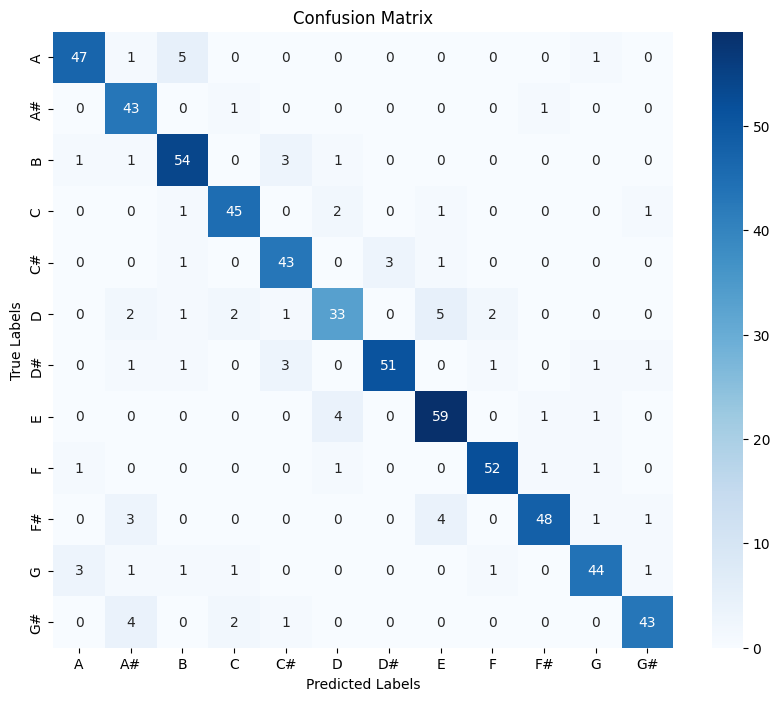

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        54
           1       0.77      0.96      0.85        45
           2       0.84      0.90      0.87        60
           3       0.88      0.90      0.89        50
           4       0.84      0.90      0.87        48
           5       0.80      0.72      0.76        46
           6       0.94      0.86      0.90        59
           7       0.84      0.91      0.87        65
           8       0.93      0.93      0.93        56
           9       0.94      0.84      0.89        57
          10       0.90      0.85      0.87        52
          11       0.91      0.86      0.89        50

    accuracy                           0.88       642
   macro avg       0.88      0.87      0.87       642
weighted avg       0.88      0.88      0.88       642



In [28]:
# Running inference on test set
y_pred = rf_classifier.predict(X_normal)
# Computing classification metrics
classification_metrics = classification_report(y_normal, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_normal, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)


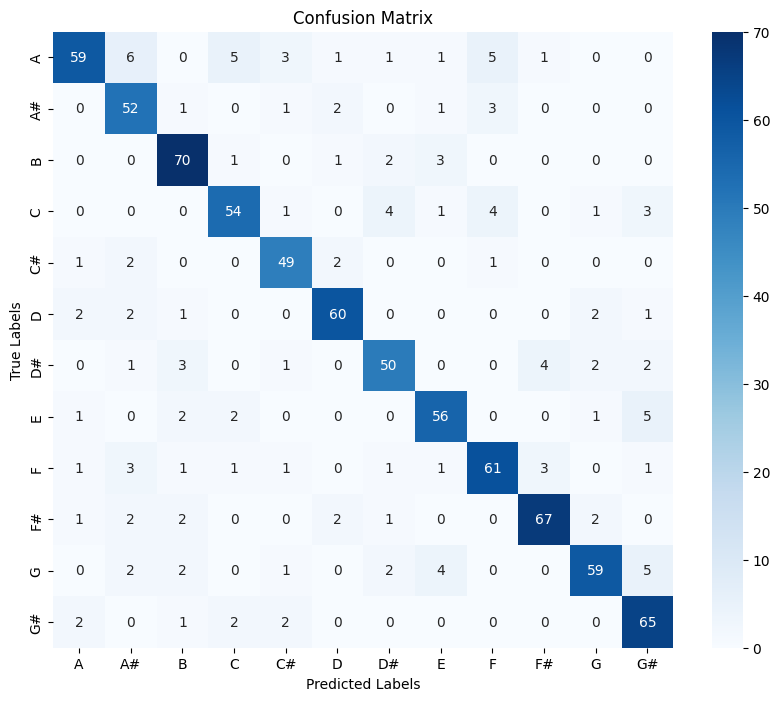

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        82
           1       0.74      0.87      0.80        60
           2       0.84      0.91      0.88        77
           3       0.83      0.79      0.81        68
           4       0.83      0.89      0.86        55
           5       0.88      0.88      0.88        68
           6       0.82      0.79      0.81        63
           7       0.84      0.84      0.84        67
           8       0.82      0.82      0.82        74
           9       0.89      0.87      0.88        77
          10       0.88      0.79      0.83        75
          11       0.79      0.90      0.84        72

    accuracy                           0.84       838
   macro avg       0.84      0.84      0.84       838
weighted avg       0.84      0.84      0.84       838



In [29]:

# Running inference on test set
y_pred = rf_classifier.predict(X_inversions)
# Computing classification metrics
classification_metrics = classification_report(y_inversions, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_inversions, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)

Ahora vamos a probar a coger el máximo valor del chromagram 

In [30]:
def max_chroma_classifier(df): 
    list_pred = []
    for index, row in df.iterrows(): 
        max_chroma = row[0:12].idxmax()
        max_chroma = int(max_chroma.split(':')[0])
        max_chroma += 3 
        max_chroma = max_chroma % 12
        list_pred.append(max_chroma)
    dict = {'root_note': list_pred} 
    return pd.DataFrame(dict)

In [31]:
X_normal.head()

,0:C,1:C#,2:D,3:D#,4:E,5:F,6:F#,7:G,8:G#,9:A,10:A#,11:B
2473,0.582174,0.525134,0.501014,0.804495,0.434523,0.491550,0.690473,0.856031,2.000000,0.725605,0.439862,0.423205
6730,1.162634,1.679075,0.868759,0.888252,1.784602,1.119492,1.115356,1.838520,1.352976,0.685662,0.644026,1.444871
2847,0.988509,1.289421,1.215947,2.000000,0.953104,0.959089,1.497952,1.121336,0.794709,0.933809,1.261016,0.783790
2036,0.675620,0.544349,0.628717,1.030611,0.834198,1.188546,2.000000,0.912810,0.621112,0.738570,1.057219,1.416169
4500,0.880730,1.802895,0.865776,0.774767,1.626309,1.019092,1.803309,1.093111,1.382828,0.837328,0.891427,0.964697


probamos con los x_test, x_normal y x_inversion 

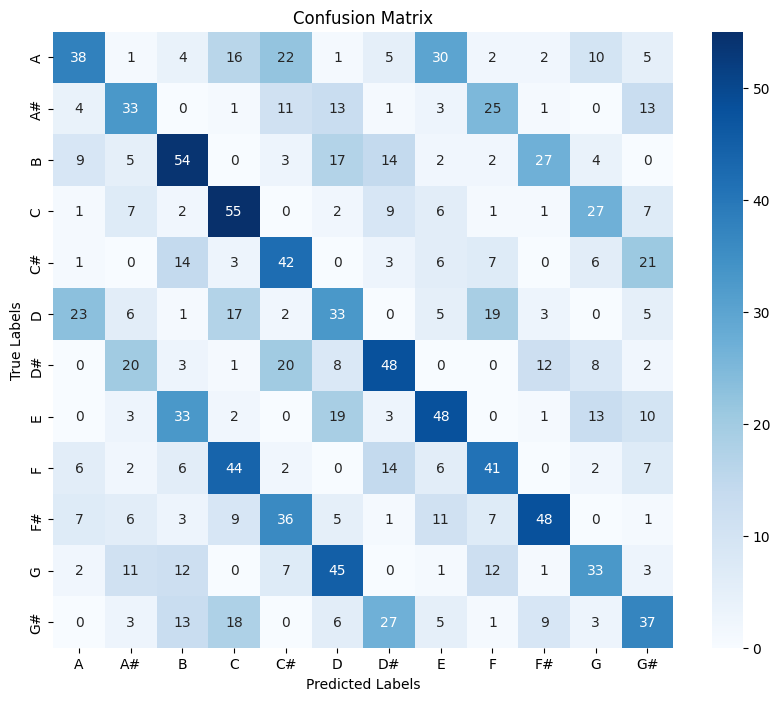

              precision    recall  f1-score   support

           0       0.42      0.28      0.33       136
           1       0.34      0.31      0.33       105
           2       0.37      0.39      0.38       137
           3       0.33      0.47      0.39       118
           4       0.29      0.41      0.34       103
           5       0.22      0.29      0.25       114
           6       0.38      0.39      0.39       122
           7       0.39      0.36      0.38       132
           8       0.35      0.32      0.33       130
           9       0.46      0.36      0.40       134
          10       0.31      0.26      0.28       127
          11       0.33      0.30      0.32       122

    accuracy                           0.34      1480
   macro avg       0.35      0.35      0.34      1480
weighted avg       0.35      0.34      0.34      1480



In [32]:

# Running inference on test set
y_pred = max_chroma_classifier(X_test)
# Computing classification metrics
classification_metrics = classification_report(y_test, y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(classification_metrics)

Vamos a hacer un SOTA MLP 

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.2923 - loss: 2.2587
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - accuracy: 0.6994 - loss: 1.1936
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.7602 - loss: 0.9429
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.7891 - loss: 0.8684
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.7930 - loss: 0.7999
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.7963 - loss: 0.8477
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.8048 - loss: 0.7915
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.8109 - loss: 0.7643
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - accuracy: 0.8122 - loss: 0.7894
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.8319 - loss: 0.7176
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.8396 - loss: 0.6790
Epoch 12/100
185/185 ━━━━━━━━━━

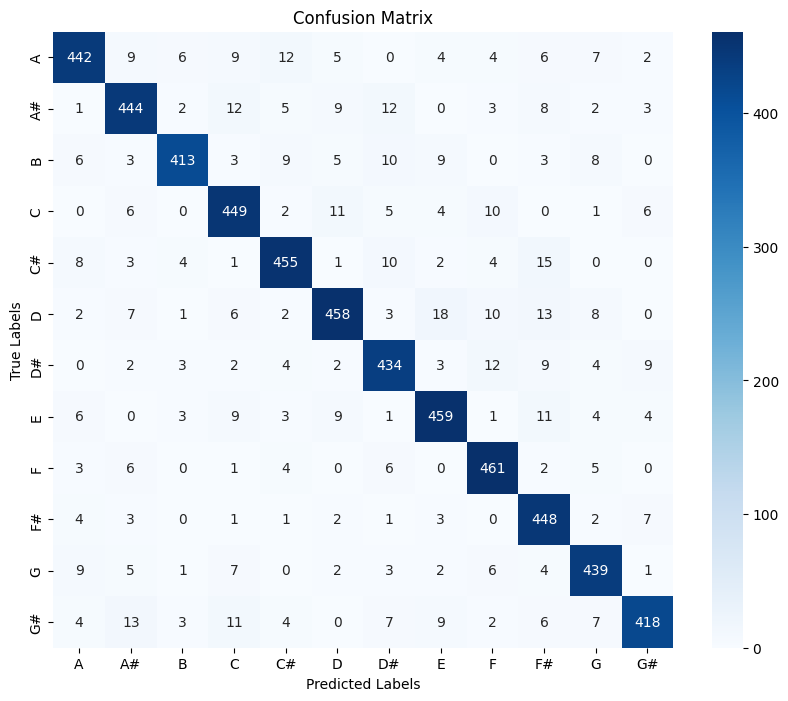

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_19 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_20 (Dense)                │ (None, 12)                │        780 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,318 (67.65 KB)

 Trainable params: 5,772 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,546 (45.11 KB)

In [33]:
# Define the MLP architecture
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Input layer with ReLU activation
        Dense(64, activation='relu'),                        # Hidden layer with ReLU activation
        Dense(num_classes, activation='softmax')             # Output layer with softmax activation
    ])
    return model

# Parameters
input_dim = 12  # Number of input features
num_classes = 12  # Number of output classes

# Build the model
model = build_model(input_dim, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy dataset for demonstration
# Generate random data for inputs and outputs
np.random.seed(0)
X_train = X_train
Y_train = y_train.to_numpy()

# Convert labels to categorical one-hot encoding
Y_train = np.eye(num_classes)[Y_train.reshape(-1)]

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert one-hot encoded labels back to class indices
Y_train_classes = np.argmax(Y_train, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(Y_train_classes, Y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(Y_train_classes, Y_pred_classes)
# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Model summary
model.summary()

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.1138 - loss: 2.4486
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.3910 - loss: 2.2863
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.5838 - loss: 2.1000
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.7032 - loss: 1.8821
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.7263 - loss: 1.7111
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.7452 - loss: 1.5328
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.8035 - loss: 1.3419
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.8022 - loss: 1.1676
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.8228 - loss: 1.0037
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.8177 - loss: 0.9936
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.8123 - loss: 0.9885
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step

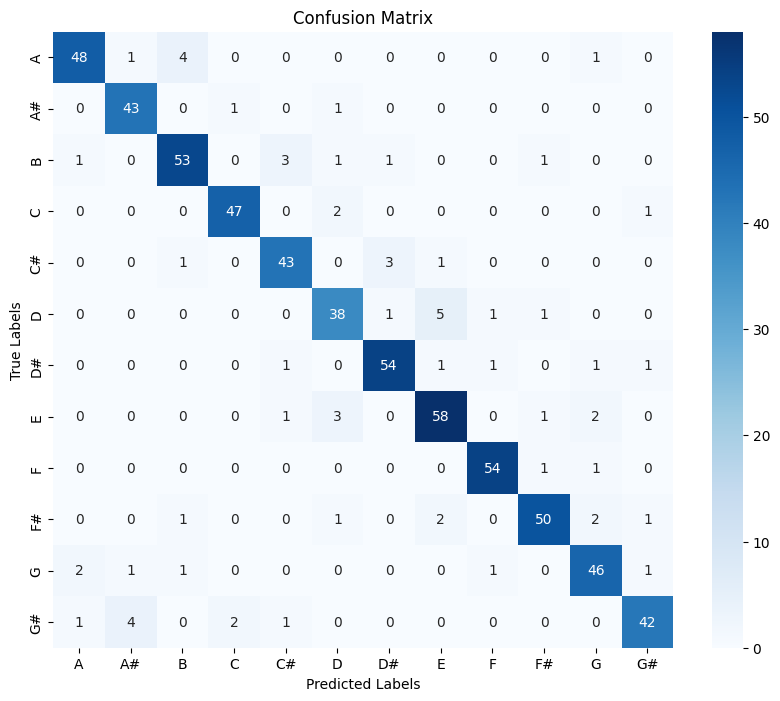

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_22 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_23 (Dense)                │ (None, 12)                │        780 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,318 (67.65 KB)

 Trainable params: 5,772 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,546 (45.11 KB)

In [34]:
# Define the MLP architecture
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Input layer with ReLU activation
        Dense(64, activation='relu'),                        # Hidden layer with ReLU activation
        Dense(num_classes, activation='softmax')             # Output layer with softmax activation
    ])
    return model

# Parameters
input_dim = 12  # Number of input features
num_classes = 12  # Number of output classes

# Build the model
model = build_model(input_dim, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy dataset for demonstration
# Generate random data for inputs and outputs
np.random.seed(0)
X_train = X_normal
Y_train = y_normal.to_numpy()

# Convert labels to categorical one-hot encoding
Y_train = np.eye(num_classes)[Y_train.reshape(-1)]

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert one-hot encoded labels back to class indices
Y_train_classes = np.argmax(Y_train, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(Y_train_classes, Y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(Y_train_classes, Y_pred_classes)
# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Model summary
model.summary()

Epoch 1/100


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.1024 - loss: 2.4931 
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.3522 - loss: 2.2951
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5031 - loss: 2.1240
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.5176 - loss: 1.9513
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.5481 - loss: 1.7760
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.5923 - loss: 1.6249
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.6241 - loss: 1.5101
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.6347 - loss: 1.3993
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.6235 - loss: 1.3319
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.6798 - loss: 1.2112
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.6694 - loss: 1.1697
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/ste

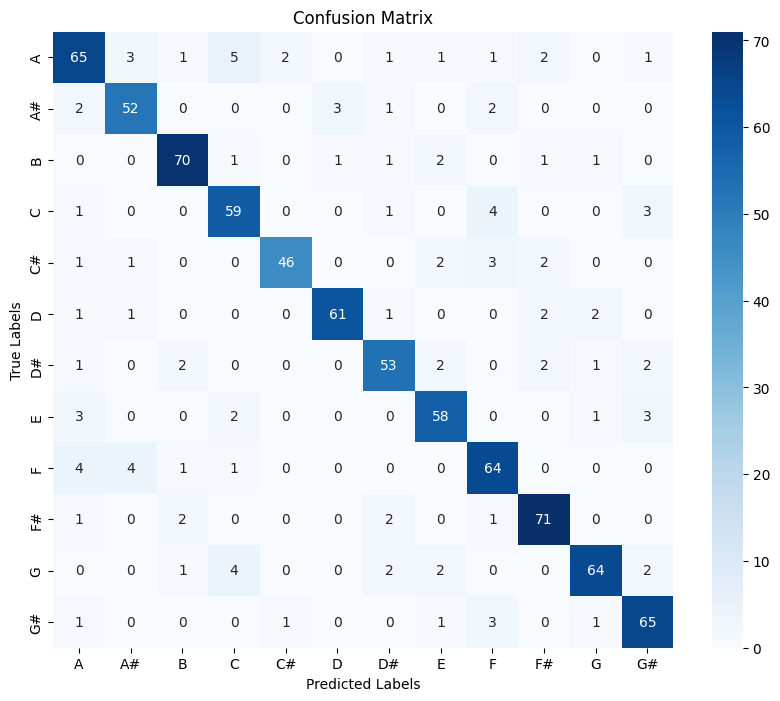

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_25 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_26 (Dense)                │ (None, 12)                │        780 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,318 (67.65 KB)

 Trainable params: 5,772 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,546 (45.11 KB)

In [35]:
# Define the MLP architecture
def build_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),  # Input layer with ReLU activation
        Dense(64, activation='relu'),                        # Hidden layer with ReLU activation
        Dense(num_classes, activation='softmax')             # Output layer with softmax activation
    ])
    return model

# Parameters
input_dim = 12  # Number of input features
num_classes = 12  # Number of output classes

# Build the model
model = build_model(input_dim, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Dummy dataset for demonstration
# Generate random data for inputs and outputs
np.random.seed(0)
X_train = X_inversions
Y_train = y_inversions.to_numpy()

# Convert labels to categorical one-hot encoding
Y_train = np.eye(num_classes)[Y_train.reshape(-1)]

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert one-hot encoded labels back to class indices
Y_train_classes = np.argmax(Y_train, axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(Y_train_classes, Y_pred_classes))

print("Confusion Matrix:")
cm = confusion_matrix(Y_train_classes, Y_pred_classes)
# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Model summary
model.summary()